> Title: *INFO 3440 Final Project: Fantasy Hockey Optimization* <br>
> Author: *Isaiah Erb* <br>
> Date: *Winter Quarter 2023* <br>

# Table of Contents<a id="Top"></a>

1. [Problem Statement](#1)<br>
2. [Data](#2) <br>
    2.1 [Data Source](#2.1)<br>
    2.2 [Another Section](#2.2)<br>
3. [Model Definition](#3)<br>
4. [Model Solution](#4)<br>
5. [Sensitivity Analysis](#5)<br>
6. [Conclusions](#6)<br>
    6.1 [Tactical Information](#6.1)<br>
    6.2 [Strategic Information](#6.2)<br>
7. [Model Limitations, Future Improvements and Challenges](#7) <br>

# 1. Problem Statement<a id=1></a>

We'd like to determine the Draft Kings fantasy hockey lineup that optimizes the statistics, specifically the total points, of each player while keeping within the following boundaries: the team must have 9 players, a maximum salary of $50,000, and include players from at least 3 different teams. There must also be two centers, two defenders, three wings, one utility (center, defender, or wing), and one goalie. In accordance with these constraints, we're incorperating two sets of data, one that describes player statistics for the entire season, and one that has the same statistics for the most recent game. Our first problem is to create the optimal lineup using the season data, and our second is to create the optimal lineup using the actual game data. 

##### [Back to Top](#Top)

# 2. Data<a id=2></a>

### Import Modules

In [1]:
import pandas as pd
import numpy as np
import pyomo.environ as pe
import matplotlib.pyplot as plt
import seaborn as sns

## 2.1 Data Source<a id=2.1></a>

### Import CSV Files and Clean Data

In [2]:
csv_salaries = pd.read_csv('DKSalaries11Feb2023.csv')
csv_season_goalie = pd.read_csv('GoaliesSeason2022-2023.csv')
csv_season_skater = pd.read_csv('SkatersSeason2022-2023.csv')
csv_actual_goalie = pd.read_csv('GoaliesActual11Feb2023.csv')
csv_actual_skater = pd.read_csv('SkatersActual11Feb2023.csv')

In [3]:
salaries_df = pd.DataFrame(csv_salaries)
season_goalie_df = pd.DataFrame(csv_season_goalie)
season_skater_df = pd.DataFrame(csv_season_skater)
actual_goalie_df = pd.DataFrame(csv_actual_goalie)
actual_skater_df = pd.DataFrame(csv_actual_skater)

#### Print DataFrames

In [4]:
salaries_df

,Position,Name + ID,Name,ID,Roster Position,Salary,Game Info,TeamAbbrev,AvgPointsPerGame
0,C,Jack Hughes (26671762),Jack Hughes,26671762,C/UTIL,8700,NJ@MIN 02/11/2023 08:00PM ET,NJ,18.16
1,C,Auston Matthews (26671764),Auston Matthews,26671764,C/UTIL,8600,CLS@TOR 02/11/2023 07:00PM ET,TOR,17.51
2,G,Connor Hellebuyck (26672442),Connor Hellebuyck,26672442,G,8500,CHI@WPG 02/11/2023 10:00PM ET,WPG,16.51
3,G,Ilya Samsonov (26672443),Ilya Samsonov,26672443,G,8400,CLS@TOR 02/11/2023 07:00PM ET,TOR,14.91
4,G,David Rittich (26672444),David Rittich,26672444,G,8300,CHI@WPG 02/11/2023 10:00PM ET,WPG,12.22
...,...,...,...,...,...,...,...,...,...
374,D,Mark Friedman (26672420),Mark Friedman,26672420,D/UTIL,2500,PIT@LA 02/11/2023 10:30PM ET,PIT,4.29
375,D,Pierre-Olivier Joseph (26672422),Pierre-Olivier Joseph,26672422,D/UTIL,2500,PIT@LA 02/11/2023 10:30PM ET,PIT,5.00
376,D,Chad Ruhwedel (26672424),Chad Ruhwedel,26672424,D/UTIL,2500,PIT@LA 02/11/2023 10:30PM ET,PIT,2.97
377,D,Taylor Fedun (26672426),Taylor Fedun,26672426,D/UTIL,2500,PIT@LA 02/11/2023 10:30PM ET,PIT,0.00


In [5]:
season_goalie_df.drop(season_goalie_df.iloc[:,16:100],inplace = True, axis=1)
season_goalie_df

,Name,Team,GP,GAA,SVPCT,W,L,GA,SV,SOG,SO,TOI,G,A,P,PIM
0,Connor Hellebuyck,WPG,40,2.45,0.923,24,15,97,1164,1261,3,2378:00,0,0,0,0
1,Jake Oettinger,DAL,40,2.22,0.926,23,7,86,1069,1155,4,2329:09,0,1,1,2
2,Ilya Sorokin,NYI,40,2.41,0.923,17,17,92,1098,1190,4,2287:58,0,0,0,0
3,Carter Hart,PHI,39,2.80,0.913,16,15,105,1103,1208,1,2246:03,0,0,0,0
4,Jordan Binnington,STL,39,3.27,0.892,18,18,122,1008,1130,2,2237:48,0,1,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,Yaroslav Askarov,NSH,1,4.15,0.886,0,1,4,31,35,0,57:50,0,0,0,0
83,Jonas Johansson,COL,1,0.00,1.000,0,0,0,7,7,0,23:15,0,0,0,0
84,Dylan Wells,CHI,1,3.00,0.923,0,0,1,12,13,0,20:00,0,0,0,0
85,Cayden Primeau,MTL,1,3.00,0.857,0,0,1,6,7,0,20:00,0,0,0,0


#### Drop Null Columns

In [6]:
season_skater_df.drop(season_skater_df.iloc[:,37:100],inplace = True, axis=1)
season_skater_df

,Name,Team,Pos,GP,G,A,P,PIM,X,TOIGP,...,GWP,OTP,PPPPCT,GGP,AGP,PGP,SHOTS,SHPCT,HITS,BS
0,Connor McDavid,EDM,W,52,41,53,94,20,6.0,22:39,...,17,2,50.00%,0.788,1.019,1.808,217.0,18.90%,47.0,30.0
1,Leon Draisaitl,EDM,W,50,29,47,76,20,2.0,21:56,...,17,2,47.40%,0.580,0.940,1.520,148.0,19.60%,34.0,30.0
2,Nikita Kucherov,TBL,W,51,20,56,76,28,4.0,20:28,...,15,1,40.80%,0.392,1.098,1.490,171.0,11.70%,40.0,20.0
3,David Pastrnak,BOS,W,51,38,34,72,32,25.0,19:43,...,14,2,38.90%,0.745,0.667,1.412,245.0,15.50%,59.0,17.0
4,Matthew Tkachuk,FLA,W,51,27,44,71,74,15.0,20:16,...,9,0,35.20%,0.529,0.863,1.392,197.0,13.70%,34.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942,Juuse Saros,NSH,G,38,0,0,0,0,NaN,NaN,...,0,0,0.00%,0.000,0.000,0.000,NaN,NaN,NaN,NaN
943,Igor Shesterkin,NYR,G,38,0,0,0,0,NaN,NaN,...,0,0,0.00%,0.000,0.000,0.000,NaN,NaN,NaN,NaN
944,Carter Hart,PHI,G,39,0,0,0,0,NaN,NaN,...,0,0,0.00%,0.000,0.000,0.000,NaN,NaN,NaN,NaN
945,Ilya Sorokin,NYI,G,40,0,0,0,0,NaN,NaN,...,0,0,0.00%,0.000,0.000,0.000,NaN,NaN,NaN,NaN


In [7]:
actual_goalie_df.drop(actual_goalie_df.iloc[:,16:100],inplace = True, axis=1)
actual_goalie_df

,Name,Team,GP,GAA,SVPCT,W,L,OTL,GA,SV,SOG,SO,TOI,G,A,P
0,Jaroslav Halak,NYR,1,2.01,0.931,1,0,0,2,27,29,0,59:50:00,0,0,0
1,Jacob Markström,CGY,1,2.00,0.913,1,0,0,2,21,23,0,60:00:00,0,1,1
2,Darcy Kuemper,WSH,1,1.00,0.964,1,0,0,1,27,28,0,60:00:00,0,0,0
3,Jordan Binnington,STL,1,4.92,0.821,1,0,0,5,23,28,0,61:02:00,0,0,0
4,Jack Campbell,EDM,1,3.01,0.897,1,0,0,3,26,29,0,59:43:00,0,0,0
5,Andrei Vasilevski,TBL,1,1.00,0.966,1,0,0,1,28,29,0,59:57:00,0,0,0
6,Elvis Merzlikins,CBJ,1,3.00,0.897,1,0,0,3,26,29,0,60:00:00,0,0,0
7,Ville Husso,DET,1,2.03,0.941,1,0,0,2,32,34,0,59:00:00,0,0,0
8,Juuse Saros,NSH,1,1.00,0.958,1,0,0,1,23,24,0,60:11:00,0,0,0
9,Pheonix Copley,LAK,1,0.00,1.000,1,0,0,0,25,25,1,60:00:00,0,0,0


In [8]:
actual_skater_df.drop(actual_skater_df.iloc[:,37:100],inplace = True, axis=1)
actual_skater_df

,Name,Team,Pos,GP,G,A,P,PIM,X,TOIGP,...,GWP,OTP,PPPPCT,GGP,AGP,PGP,SHOTS,SHPCT,HITS,BS
0,Artemi Panarin,NYR,F,1,4,1,5,2,4.0,15:31,...,1,0,20.00%,4,1,5,5.0,80.00%,0.0,0.0
1,Adrian Kempe,LAK,F,1,4,0,4,2,2.0,17:45,...,0,0,50.00%,4,0,4,7.0,57.10%,1.0,0.0
2,Nick Schmaltz,ARI,F,1,1,3,4,0,2.0,18:36,...,0,0,50.00%,1,3,4,2.0,50.00%,1.0,0.0
3,Dillon Dube,CGY,F,1,1,3,4,0,2.0,16:06,...,1,0,25.00%,1,3,4,3.0,33.30%,1.0,1.0
4,Juuso Välimäki,ARI,D,1,0,4,4,2,0.0,21:52,...,0,0,50.00%,0,4,4,1.0,0.00%,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,Dylan Holloway,EDM,F,1,0,0,0,0,-1.0,10:52,...,0,0,0.00%,0,0,0,1.0,0.00%,1.0,0.0
530,Alex Newhook,COL,F,1,0,0,0,0,0.0,10:33,...,0,0,0.00%,0,0,0,1.0,0.00%,0.0,1.0
531,Wyatt Johnston,DAL,F,1,0,0,0,0,1.0,16:10,...,0,0,0.00%,0,0,0,2.0,0.00%,0.0,0.0
532,Tim Stützle,OTT,F,1,0,0,0,0,0.0,19:40,...,0,0,0.00%,0,0,0,2.0,0.00%,1.0,2.0


## 2.2 Summary Statistics and Creating Final DataFrames<a id=2.2></a>

#### Summary Statistics

In [9]:
season_goalie_df.describe()

,GP,GAA,SVPCT,W,L,GA,SV,SOG,SO,G,A,P,PIM
count,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.0,87.000000,87.000000,87.000000
mean,20.068966,2.904828,0.907011,9.494253,7.413793,55.758621,537.885057,593.643678,0.862069,0.0,0.298851,0.298851,0.965517
std,11.656711,0.730622,0.021671,6.797526,5.077428,33.224384,330.092955,361.862655,1.101504,0.0,0.530795,0.530795,2.175168
min,1.000000,0.000000,0.857000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,13.000000,2.560000,0.897000,4.500000,4.000000,34.500000,322.000000,357.500000,0.000000,0.0,0.000000,0.000000,0.000000
50%,19.000000,2.920000,0.906000,9.000000,6.000000,48.000000,497.000000,549.000000,0.000000,0.0,0.000000,0.000000,0.000000
75%,28.500000,3.285000,0.916500,13.500000,11.500000,83.000000,790.000000,884.500000,1.000000,0.0,1.000000,1.000000,2.000000
max,40.000000,4.420000,1.000000,26.000000,21.000000,132.000000,1184.000000,1316.000000,4.000000,0.0,2.000000,2.000000,12.000000


In [10]:
season_skater_df.describe()

,GP,G,A,P,PIM,X,ESG,PPG,SHG,GWG,...,PPP,SHP,GWP,OTP,GGP,AGP,PGP,SHOTS,HITS,BS
count,947.000000,947.000000,947.000000,947.000000,947.000000,860.000000,947.000000,947.000000,947.000000,947.000000,...,860.000000,860.000000,947.000000,947.000000,947.000000,947.000000,947.000000,860.000000,860.000000,860.000000
mean,33.313622,5.453010,9.254488,14.707497,15.881732,-0.368605,4.097149,1.200634,0.155227,0.818374,...,3.840698,0.361628,2.211193,0.357973,0.128597,0.221416,0.350007,60.524419,44.510465,28.402326
std,17.958487,6.843668,10.035227,15.909628,15.839335,9.015712,4.795287,2.476076,0.480246,1.315367,...,6.448071,0.778445,2.931163,0.804091,0.140671,0.201020,0.310640,48.766585,38.258159,27.340240
min,1.000000,0.000000,0.000000,0.000000,0.000000,-30.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,0.000000,1.000000,2.000000,2.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.067000,0.111000,18.000000,14.000000,9.000000
50%,39.000000,3.000000,6.000000,10.000000,12.000000,-0.500000,3.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.094000,0.176000,0.278000,53.000000,34.000000,19.000000
75%,50.000000,8.000000,14.000000,22.000000,24.000000,4.000000,7.000000,1.000000,0.000000,1.000000,...,5.000000,0.000000,3.000000,0.000000,0.192000,0.327000,0.500000,88.000000,64.000000,38.250000
max,55.000000,41.000000,56.000000,94.000000,92.000000,33.000000,29.000000,17.000000,4.000000,9.000000,...,47.000000,7.000000,17.000000,7.000000,0.788000,1.098000,1.808000,245.000000,244.000000,156.000000


#### Add Aggragate Total Points Column

In [11]:
season_skater_df['HT'] = np.where(season_skater_df['G']>=3,season_skater_df['G']*3,0)
season_skater_df['5S'] = np.where(season_skater_df['SHOTS']>=5,season_skater_df['SHOTS']*3,0)
season_skater_df['3BS'] = np.where(season_skater_df['BS']>=3,season_skater_df['BS']*3,0)
season_skater_df['3P'] = np.where(season_skater_df['P']>=3,season_skater_df['P']*3,0)
season_skater_df['totalpoints'] = (season_skater_df['G'] * 8.5 + season_skater_df['A'] * 5 + season_skater_df['SHOTS'] * 1.5 + season_skater_df['BS'] * 1.3 + season_skater_df['SHOUTG'] *1.5 + season_skater_df['HT'] * 3 + + season_skater_df['5S'] * 3 + season_skater_df['3BS'] * 3 + season_skater_df['3P'] *3 + season_skater_df['SHG'] * 2 + season_skater_df['SHA'] * 2) / season_skater_df['GP']
season_skater_df['Name'] = season_skater_df['Name'].str.replace('ä','a').str.replace('ö','o')
season_skater_df.drop(season_skater_df[season_skater_df['Pos'] == 'G'].index,inplace=True)
season_skater_df.sort_values(by=['totalpoints'],ascending=False)

,Name,Team,Pos,GP,G,A,P,PIM,X,TOIGP,...,PGP,SHOTS,SHPCT,HITS,BS,HT,5S,3BS,3P,totalpoints
0,Connor McDavid,EDM,W,52,41,53,94,20,6.0,22:39,...,1.808,217.0,18.90%,47.0,30.0,123,651.0,90.0,282,85.000000
22,Nathan MacKinnon,COL,W,39,14,41,55,20,13.0,22:31,...,1.410,202.0,6.90%,28.0,22.0,42,606.0,66.0,165,84.464103
3,David Pastrnak,BOS,W,51,38,34,72,32,25.0,19:43,...,1.412,245.0,15.50%,59.0,17.0,114,735.0,51.0,216,82.982353
83,Roman Josi,NSH,D,49,12,30,42,24,3.0,25:06:00,...,0.857,205.0,5.90%,38.0,111.0,36,615.0,333.0,126,82.322449
28,Auston Matthews,TOR,C,47,25,28,53,16,19.0,20:15,...,1.128,200.0,12.50%,60.0,63.0,75,600.0,189.0,159,80.955319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,Oskar Olausson,COL,W,1,0,0,0,0,0.0,7:02,...,0.000,0.0,0.00%,0.0,0.0,0,0.0,0.0,0,0.000000
802,Hayden Hodgson,PHI,W,1,0,0,0,0,0.0,4:46,...,0.000,0.0,0.00%,0.0,0.0,0,0.0,0.0,0,0.000000
825,Tyler Benson,EDM,W,2,0,0,0,0,0.0,6:17,...,0.000,0.0,0.00%,2.0,0.0,0,0.0,0.0,0,0.000000
808,Gabriel Fortier,TBL,W,1,0,0,0,0,0.0,8:25,...,0.000,0.0,0.00%,1.0,0.0,0,0.0,0.0,0,0.000000


In [12]:
actual_skater_df['HT'] = np.where(actual_skater_df['G']>=3,1,0)
actual_skater_df['5S'] = np.where(actual_skater_df['SHOTS']>=5,1,0)
actual_skater_df['3BS'] = np.where(actual_skater_df['BS']>=3,1,0)
actual_skater_df['3P'] = np.where(actual_skater_df['P']>=3,1,0)
actual_skater_df['totalpoints'] = actual_skater_df['G'] * 8.5 + actual_skater_df['A'] * 5 + actual_skater_df['SHOTS'] * 1.5 + actual_skater_df['BS'] * 1.3 + actual_skater_df['SHOUTG'] *1.5 + actual_skater_df['HT'] * 3 + + actual_skater_df['5S'] * 3 + actual_skater_df['3BS'] * 3 + actual_skater_df['3P'] *3 + actual_skater_df['SHG'] * 2 + actual_skater_df['SHA'] * 2
actual_skater_df['Name'] = actual_skater_df['Name'].str.replace('ä','a').str.replace('ö','o')
actual_skater_df.drop(actual_skater_df[actual_skater_df['Pos'] == 'G'].index,inplace=True)
actual_skater_df.sort_values(by=['totalpoints'],ascending=False)

,Name,Team,Pos,GP,G,A,P,PIM,X,TOIGP,...,PGP,SHOTS,SHPCT,HITS,BS,HT,5S,3BS,3P,totalpoints
0,Artemi Panarin,NYR,F,1,4,1,5,2,4.0,15:31,...,5,5.0,80.00%,0.0,0.0,1,1,0,1,55.5
1,Adrian Kempe,LAK,F,1,4,0,4,2,2.0,17:45,...,4,7.0,57.10%,1.0,0.0,1,1,0,1,53.5
7,Nathan MacKinnon,COL,F,1,2,1,3,0,0.0,23:55,...,3,6.0,33.30%,1.0,1.0,0,1,0,1,38.3
8,Dylan Larkin,DET,F,1,2,1,3,0,1.0,22:29,...,3,5.0,40.00%,0.0,1.0,0,1,0,1,36.8
6,Tyler Toffoli,CGY,F,1,2,1,3,0,2.0,14:25,...,3,5.0,40.00%,1.0,0.0,0,1,0,1,35.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,Dylan Gambrell,OTT,F,1,0,0,0,2,-2.0,9:54,...,0,0.0,0.00%,1.0,0.0,0,0,0,0,0.0
218,Vladimir Tarasenko,NYR,F,1,0,0,0,0,0.0,13:25,...,0,0.0,0.00%,2.0,0.0,0,0,0,0,0.0
465,Dakota Joshua,VAN,F,1,0,0,0,0,0.0,14:10,...,0,0.0,0.00%,0.0,0.0,0,0,0,0,0.0
275,Charlie Coyle,BOS,F,1,0,0,0,2,1.0,16:40,...,0,0.0,0.00%,1.0,0.0,0,0,0,0,0.0


In [13]:
actual_goalie_df['35S'] = np.where(actual_goalie_df['SV']>=35,1,0)
actual_goalie_df['totalpoints'] = actual_goalie_df['W'] * 6 + actual_goalie_df['SV'] * 0.7 - actual_goalie_df['GA'] * 3.5 + actual_goalie_df['SO'] * 4 + actual_goalie_df['35S']*3 + actual_goalie_df['OTL']*2
actual_goalie_df['Name'] = actual_goalie_df['Name'].str.replace('ä','a').str.replace('ö','o')
actual_goalie_df.sort_values(by=['totalpoints'],ascending=False)

,Name,Team,GP,GAA,SVPCT,W,L,OTL,GA,SV,SOG,SO,TOI,G,A,P,35S,totalpoints
11,Alexandar Georgiev,COL,1,3.00,0.933,1,0,0,3,42,45,0,60:00:00,0,0,0,1,27.9
9,Pheonix Copley,LAK,1,0.00,1.000,1,0,0,0,25,25,1,60:00:00,0,0,0,0,27.5
10,Connor Hellebuyck,WPG,1,1.00,0.969,1,0,0,1,31,32,0,60:00:00,0,0,0,0,24.2
5,Andrei Vasilevski,TBL,1,1.00,0.966,1,0,0,1,28,29,0,59:57:00,0,0,0,0,22.1
2,Darcy Kuemper,WSH,1,1.00,0.964,1,0,0,1,27,28,0,60:00:00,0,0,0,0,21.4
7,Ville Husso,DET,1,2.03,0.941,1,0,0,2,32,34,0,59:00:00,0,0,0,0,21.4
16,Sergei Bobrovsky,FLA,1,4.14,0.918,0,1,0,4,45,49,0,57:59:00,0,0,0,1,20.5
8,Juuse Saros,NSH,1,1.00,0.958,1,0,0,1,23,24,0,60:11:00,0,0,0,0,18.6
12,Filip Gustavsson,MIN,1,1.85,0.931,1,0,0,2,27,29,0,65:00:00,0,0,0,0,17.9
0,Jaroslav Halak,NYR,1,2.01,0.931,1,0,0,2,27,29,0,59:50:00,0,0,0,0,17.9


In [14]:
season_goalie_df['35S'] = np.where(season_goalie_df['SV']>=35,1,0)
season_goalie_df['totalpoints'] = (season_goalie_df['W'] * 6 + season_goalie_df['SV'] * 0.7 - season_goalie_df['GA'] * 3.5 + season_goalie_df['SO'] * 4 + season_goalie_df['35S']*3) / season_goalie_df['GP']
season_goalie_df['Name'] = season_goalie_df['Name'].str.replace('ä','a').str.replace('ö','o')
season_goalie_df.sort_values(by=['totalpoints'],ascending=False)

,Name,Team,GP,GAA,SVPCT,W,L,GA,SV,SOG,SO,TOI,G,A,P,PIM,35S,totalpoints
81,Keith Kinkaid,BOS,1,1.00,0.968,1,0,1,30,31,0,59:54,0,0,0,0,0,23.500000
80,Joel Daccord,SEA,1,4.00,0.900,1,0,4,36,40,0,60:00,0,0,0,0,1,20.200000
76,Jaxson Stauber,CHI,3,2.29,0.925,3,0,7,86,93,0,183:30,0,0,0,0,1,18.900000
16,Linus Ullmark,BOS,33,1.90,0.937,26,4,61,901,962,2,1921:51,0,0,0,2,1,17.703030
25,Tristan Jarry,PIT,27,2.65,0.921,16,5,70,816,886,1,1583:36,0,2,2,2,1,15.896296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,Elvis Merzlikins,CBJ,21,4.42,0.870,5,14,82,548,630,0,1114:18,0,0,0,4,1,6.171429
83,Jonas Johansson,COL,1,0.00,1.000,0,0,0,7,7,0,23:15,0,0,0,0,0,4.900000
84,Dylan Wells,CHI,1,3.00,0.923,0,0,1,12,13,0,20:00,0,0,0,0,0,4.900000
86,Matthew Berlin,EDM,1,0.00,1.000,0,0,0,1,1,0,2:26,0,0,0,0,0,0.700000


### Modify and Combine DataFrames

#### Modify DataFrames to Only Include Name, Team, and Total Points

In [15]:
actual_goalie_modified = actual_goalie_df.drop(actual_goalie_df.columns[[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]],axis=1)
actual_goalie_modified

,Name,Team,totalpoints
0,Jaroslav Halak,NYR,17.9
1,Jacob Markstrom,CGY,13.7
2,Darcy Kuemper,WSH,21.4
3,Jordan Binnington,STL,4.6
4,Jack Campbell,EDM,13.7
5,Andrei Vasilevski,TBL,22.1
6,Elvis Merzlikins,CBJ,13.7
7,Ville Husso,DET,21.4
8,Juuse Saros,NSH,18.6
9,Pheonix Copley,LAK,27.5


In [16]:
actual_skater_modified = actual_skater_df.drop(actual_skater_df.columns[[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40]],axis=1)
actual_skater_modified

,Name,Team,totalpoints
0,Artemi Panarin,NYR,55.5
1,Adrian Kempe,LAK,53.5
2,Nick Schmaltz,ARI,29.5
3,Dillon Dube,CGY,32.3
4,Juuso Valimaki,ARI,31.4
...,...,...,...
529,Dylan Holloway,EDM,1.5
530,Alex Newhook,COL,2.8
531,Wyatt Johnston,DAL,3.0
532,Tim Stützle,OTT,5.6


In [17]:
season_goalie_modified = season_goalie_df.drop(season_goalie_df.columns[[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]],axis=1)
season_goalie_modified 

,Name,Team,totalpoints
0,Connor Hellebuyck,WPG,15.857500
1,Jake Oettinger,DAL,15.107500
2,Ilya Sorokin,NYI,14.190000
3,Carter Hart,PHI,13.015385
4,Jordan Binnington,STL,10.194872
...,...,...,...
82,Yaroslav Askarov,NSH,7.700000
83,Jonas Johansson,COL,4.900000
84,Dylan Wells,CHI,4.900000
85,Cayden Primeau,MTL,0.700000


In [18]:
season_skater_modified = season_skater_df.drop(season_skater_df.columns[[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40]],axis=1)
season_skater_modified

,Name,Team,totalpoints
0,Connor McDavid,EDM,85.000000
1,Leon Draisaitl,EDM,65.830000
2,Nikita Kucherov,TBL,65.009804
3,David Pastrnak,BOS,82.982353
4,Matthew Tkachuk,FLA,71.552941
...,...,...,...
901,Carson Meyer,CBJ,17.676923
904,Anton Blidh,COL,6.935714
924,Markus Niemelainen,EDM,14.469565
933,Jake Leschyshyn,NYR,12.540000


#### Modify Salaries DataFrame to Include Position, Name, and Salary

In [19]:
salaries_modified = salaries_df.drop(salaries_df.columns[[1,3,4,6,7,8]],axis=1)
salaries_modified

,Position,Name,Salary
0,C,Jack Hughes,8700
1,C,Auston Matthews,8600
2,G,Connor Hellebuyck,8500
3,G,Ilya Samsonov,8400
4,G,David Rittich,8300
...,...,...,...
374,D,Mark Friedman,2500
375,D,Pierre-Olivier Joseph,2500
376,D,Chad Ruhwedel,2500
377,D,Taylor Fedun,2500


#### Combine DataFrames

In [20]:
season_combined = pd.concat([season_skater_modified,season_goalie_modified],ignore_index=True,axis=0)
season_combined

,Name,Team,totalpoints
0,Connor McDavid,EDM,85.000000
1,Leon Draisaitl,EDM,65.830000
2,Nikita Kucherov,TBL,65.009804
3,David Pastrnak,BOS,82.982353
4,Matthew Tkachuk,FLA,71.552941
...,...,...,...
942,Yaroslav Askarov,NSH,7.700000
943,Jonas Johansson,COL,4.900000
944,Dylan Wells,CHI,4.900000
945,Cayden Primeau,MTL,0.700000


In [21]:
actual_combined = pd.concat([actual_skater_modified,actual_goalie_modified],ignore_index=True,axis=0)
actual_combined

,Name,Team,totalpoints
0,Artemi Panarin,NYR,55.5
1,Adrian Kempe,LAK,53.5
2,Nick Schmaltz,ARI,29.5
3,Dillon Dube,CGY,32.3
4,Juuso Valimaki,ARI,31.4
...,...,...,...
529,Ukko-Pekka Luukkonen,BUF,-1.4
530,Joseph Woll,TOR,14.2
531,Carter Hart,PHI,11.1
532,Jeremy Swayman,BOS,7.7


### Merge and Create Final Season and Actual DataFrames

In [22]:
df_season = pd.DataFrame(salaries_modified)
df_season = df_season.merge(season_combined,left_on='Name',right_on='Name')
df_season = df_season.dropna(subset=['totalpoints'])
df_season

,Position,Name,Salary,Team,totalpoints
0,C,Jack Hughes,8700,NJD,78.278000
1,C,Auston Matthews,8600,TOR,80.955319
2,G,Connor Hellebuyck,8500,WPG,15.857500
3,G,Ilya Samsonov,8400,TOR,14.396000
4,G,David Rittich,8300,WPG,12.215385
...,...,...,...,...,...
319,D,Jan Rutta,2500,PIT,29.561905
320,D,Mark Friedman,2500,PIT,23.790000
321,D,Pierre-Olivier Joseph,2500,PIT,25.553191
322,D,Chad Ruhwedel,2500,PIT,18.159375


In [23]:
df_actual = pd.DataFrame(salaries_modified)
df_actual = df_actual.merge(actual_combined,left_on='Name',right_on='Name')
df_actual = df_actual.dropna(subset=['totalpoints'])
df_actual

,Position,Name,Salary,Team,totalpoints
0,G,Connor Hellebuyck,8500,WPG,24.2
1,G,Joseph Woll,8200,TOR,14.2
2,G,Frederik Andersen,8200,CAR,-8.4
3,G,Jordan Binnington,8100,STL,4.6
4,G,Pheonix Copley,7900,LAK,27.5
...,...,...,...,...,...
211,C,Rasmus Kupari,2500,LAK,11.5
212,C,Blake Lizotte,2500,LAK,0.0
213,RW,Josh Archibald,2500,PIT,1.5
214,D,Mark Friedman,2500,PIT,7.1


##### [Back to Top](#Top)

# 3. Model Definition<a id=3><a>

#### Define the Variable "salarycap" to be Used in Each Model

In [24]:
salarycap = 50000

#### Define List DV_Indexes for Both Models

In [25]:
DV_indexes = ['Position','Name','Salary','Team','totalpoints']

### M1: Season

#### Lists and Dictionaries for Players, Total Points, Salary, Position, and Teams for Season Model

In [26]:
PLAYERS_SEASON = list(set(df_season['Name']))
totalpoints_season = df_season.set_index(['Name'])['totalpoints'].to_dict()
salary_season = df_season.set_index(['Name'])['Salary'].to_dict()
TEAMS_SEASON = df_season.set_index(['Name'])['Team'].to_dict()
POSITIONS_SEASON = df_season.set_index(['Name'])['Position'].to_dict()
teams_season = df_season.groupby('Team')

#### Create Season Model, Define Decision Variables and Objective Function

In [27]:
model_season = pe.ConcreteModel()

In [28]:
model_season.x = pe.Var(PLAYERS_SEASON,domain=pe.Binary,initialize=0)

In [29]:
#Model Objective: maximize total points
model_season.obj = pe.Objective(expr=sum([totalpoints_season[p]*model_season.x[p] for p in PLAYERS_SEASON]),sense=pe.maximize)

#### Define Constraints

In [30]:
#9 players
model_season.con_players = pe.Constraint(expr=sum([model_season.x[p] for p in PLAYERS_SEASON])==9)
#50,000 salary cap
model_season.con_salary = pe.Constraint(expr=sum([model_season.x[p]*salary_season[p] for p in PLAYERS_SEASON])<=salarycap)
#team constraint
model_season.con_teams = pe.Constraint(expr=sum(model_season.x[p] for p in PLAYERS_SEASON if teams_season['Team']) >= 3)
#position constraints (no utility, satisfied using these four constraints)
model_season.con_center = pe.Constraint(expr=sum(model_season.x[p] for p in PLAYERS_SEASON if 'C' in POSITIONS_SEASON[p]) >= 2)
model_season.con_wings = pe.Constraint(expr=sum(model_season.x[p] for p in PLAYERS_SEASON if 'LW' in POSITIONS_SEASON[p] or 'RW' in POSITIONS_SEASON[p]) >= 3)
model_season.con_defesnders = pe.Constraint(expr=sum(model_season.x[p] for p in PLAYERS_SEASON if 'D' in POSITIONS_SEASON[p]) >= 2)
model_season.con_goalie = pe.Constraint(expr=sum(model_season.x[p] for p in PLAYERS_SEASON if 'G' in POSITIONS_SEASON[p]) == 1)

### M2: Actual

#### Lists and Dictionaries for Players, Total Points, Salary, Position, and Teams for Actual Model

In [31]:
PLAYERS_ACTUAL = list(set(df_actual['Name']))
totalpoints_actual = df_actual.set_index(['Name'])['totalpoints'].to_dict()
salary_actual = df_actual.set_index(['Name'])['Salary'].to_dict()
TEAMS_ACTUAL = df_actual.set_index(['Name'])['Team'].to_dict()
POSITIONS_ACTUAL = df_actual.set_index(['Name'])['Position'].to_dict()
teams_actual = df_actual.groupby('Team')

#### Create Season Model, Define Decision Variables and Objective Function

In [32]:
model_actual = pe.ConcreteModel()

In [33]:
model_actual.x = pe.Var(PLAYERS_ACTUAL,domain=pe.Binary,initialize=0)

In [34]:
#Model Objective: maximize total points
model_actual.obj = pe.Objective(expr=sum([totalpoints_actual[p]*model_actual.x[p] for p in PLAYERS_ACTUAL]),sense=pe.maximize)

#### Define Constraints

In [35]:
#9 players
model_actual.con_players = pe.Constraint(expr=sum([model_actual.x[p] for p in PLAYERS_ACTUAL])==9)
#50,000 salary cap
model_actual.con_salary = pe.Constraint(expr=sum([model_actual.x[p]*salary_actual[p] for p in PLAYERS_ACTUAL])<=salarycap)
#team constraint
model_actual.con_teams = pe.Constraint(expr=sum(model_actual.x[p] for p in PLAYERS_ACTUAL if teams_actual['Team']) >= 3)
#position constraints (no utility, satisfied using these four constraints)
model_actual.con_center = pe.Constraint(expr=sum(model_actual.x[p] for p in PLAYERS_ACTUAL if 'C' in POSITIONS_ACTUAL[p]) >= 2)
model_actual.con_wings = pe.Constraint(expr=sum(model_actual.x[p] for p in PLAYERS_ACTUAL if 'LW' in POSITIONS_ACTUAL[p] or 'RW' in POSITIONS_ACTUAL[p]) >= 3)
model_actual.con_defenders = pe.Constraint(expr=sum(model_actual.x[p] for p in PLAYERS_ACTUAL if 'D' in POSITIONS_ACTUAL[p]) >= 2)
model_actual.con_goalie = pe.Constraint(expr=sum(model_actual.x[p] for p in PLAYERS_ACTUAL if 'G' in POSITIONS_ACTUAL[p]) == 1)

##### [Back to Top](#Top)

# 4. Model Solution<a id=4></a>

### M1: Season 

#### Use GLPK Solver Engine to Find Optimal Solution

In [36]:
opt = pe.SolverFactory('glpk')
success = opt.solve(model_season,tee=True)
print(success.solver.status, success.solver.termination_condition)

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpt5u537eg.glpk.raw
 --wglp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpubdky5gw.glpk.glp
 --cpxlp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp9y6llvmv.pyomo.lp
Reading problem data from '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp9y6llvmv.pyomo.lp'...
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp9y6llvmv.pyomo.lp:1974: warning: lower bound of variable 'x1' redefined
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp9y6llvmv.pyomo.lp:1974: warning: upper bound of variable 'x1' redefined
8 rows, 325 columns, 1297 non-zeros
324 integer variables, all of which are binary
2298 lines were read
Writing problem data to '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpubdky5gw.glpk.glp'...
1962 lines were written
GLPK Integer Optimizer, v4.65
8 rows, 325 columns, 1297 non-zeros
324 integer variables, all of which are bina

#### Total Points and Lineup for Optimal Solution

In [37]:
obj_val = model_season.obj.expr()
print(f'optimal objective value maximimizes total points = {obj_val:.2f}')

optimal objective value maximimizes total points = 486.58


In [38]:
DV_solution_season = pd.DataFrame()
for DV in model_season.component_objects(pe.Var):
    for var in DV:
        if DV[var].value==1.0:
            DV_solution_season.loc[DV.name,var] = DV[var].value
DV_solution_season.loc['totalpoints'] = totalpoints_season
DV_solution_season.loc['team'] = TEAMS_SEASON
DV_solution_season.loc['salary'] = salary_season
DV_solution_season.loc['position'] = POSITIONS_SEASON
DV_solution_season

,Vladimir Tarasenko,Martin Necas,Jake Muzzin,Jacob Moverare,Kirill Kaprizov,Jack Hughes,Ty Smith,Auston Matthews,Tristan Jarry
x,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
totalpoints,47.14359,54.280392,48.0,52.1,67.233333,78.278,42.688889,80.955319,15.896296
team,NYR,CAR,TOR,LAK,MIN,NJD,PIT,TOR,PIT
salary,4500,5700,2900,2500,7800,8700,2500,8600,6500
position,RW,RW,D,D,LW,C,D,C,G


### M2: Actual 

#### Use GLPK Solver Engine to Find Optimal Solution

In [39]:
opt = pe.SolverFactory('glpk')
success = opt.solve(model_actual,tee=True)
print(success.solver.status, success.solver.termination_condition)

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp34me6peo.glpk.raw
 --wglp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpm5vfncd7.glpk.glp
 --cpxlp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp1yjy5dwv.pyomo.lp
Reading problem data from '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp1yjy5dwv.pyomo.lp'...
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp1yjy5dwv.pyomo.lp:1307: warning: lower bound of variable 'x1' redefined
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp1yjy5dwv.pyomo.lp:1307: warning: upper bound of variable 'x1' redefined
8 rows, 217 columns, 865 non-zeros
216 integer variables, all of which are binary
1523 lines were read
Writing problem data to '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpm5vfncd7.glpk.glp'...
1295 lines were written
GLPK Integer Optimizer, v4.65
8 rows, 217 columns, 865 non-zeros
216 integer variables, all of which are binary

#### Total Points and Lineup for Optimal Solution

In [40]:
obj_val = model_actual.obj.expr()
print(f'optimal objective value maximimizes total points = {obj_val:.2f}')

optimal objective value maximimizes total points = 311.80


In [41]:
DV_solution_actual = pd.DataFrame()
for DV in model_actual.component_objects(pe.Var):
    for var in DV:
        if DV[var].value==1.0:
            DV_solution_actual.loc[DV.name,var] = DV[var].value
DV_solution_actual.loc['totalpoints'] = totalpoints_actual
DV_solution_actual.loc['team'] = TEAMS_ACTUAL
DV_solution_actual.loc['salary'] = salary_actual
DV_solution_actual.loc['position'] = POSITIONS_ACTUAL
DV_solution_actual

,Boone Jenner,Artemi Panarin,Nick Schmaltz,Morgan Rielly,Pheonix Copley,Juuso Valimaki,Anze Kopitar,Clayton Keller,Adrian Kempe
x,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
totalpoints,32.6,55.5,29.5,30.0,27.5,31.4,20.8,31.0,53.5
team,CBJ,NYR,ARI,TOR,LAK,ARI,LAK,ARI,LAK
salary,6300,6100,5000,4600,7900,3000,5600,5900,5500
position,C,LW,RW,D,G,D,C,LW,RW


##### [Back to Top](#Top)

# 5. Sensitivity Analysis<a id=5></a>

### M1: Season Sensitivity Analysis 

#### Define Function that Runs M1

In [42]:
def run_model_season():
    #define lists and dictionaries 
    PLAYERS_SEASON = list(set(df_season['Name']))
    totalpoints_season = df_season.set_index(['Name'])['totalpoints'].to_dict()
    salary_season = df_season.set_index(['Name'])['Salary'].to_dict()
    TEAMS_SEASON = df_season.set_index(['Name'])['Team'].to_dict()
    POSITIONS_SEASON = df_season.set_index(['Name'])['Position'].to_dict()
    teams_season = df_season.groupby('Team')
    
    #define model
    model_season = pe.ConcreteModel()
    
    #indexes
    DV_indexes = ['Position','Name','Salary','Team','totalpoints']

    #decision variables
    model_season.x = pe.Var(PLAYERS_SEASON,domain=pe.Binary,initialize=0)
    
    #objective function
    model_season.obj = pe.Objective(expr=sum([totalpoints_season[p]*model_season.x[p] for p in PLAYERS_SEASON]),sense=pe.maximize)
    
    #constraints
    model_season.con_players = pe.Constraint(expr=sum([model_season.x[p] for p in PLAYERS_SEASON])==9)
    model_season.con_salary = pe.Constraint(expr=sum([model_season.x[p]*salary_season[p] for p in PLAYERS_SEASON])<=salarycap)
    model_season.con_teams = pe.Constraint(expr=sum(model_season.x[p] for p in PLAYERS_SEASON if teams_season['Team']) >= 3)
    model_season.con_center = pe.Constraint(expr=sum(model_season.x[p] for p in PLAYERS_SEASON if 'C' in POSITIONS_SEASON[p]) >= 2)
    model_season.con_wings = pe.Constraint(expr=sum(model_season.x[p] for p in PLAYERS_SEASON if 'LW' in POSITIONS_SEASON[p] or 'RW' in POSITIONS_SEASON[p]) >= 3)
    model_season.con_defesnders = pe.Constraint(expr=sum(model_season.x[p] for p in PLAYERS_SEASON if 'D' in POSITIONS_SEASON[p]) >= 2)
    model_season.con_goalie = pe.Constraint(expr=sum(model_season.x[p] for p in PLAYERS_SEASON if 'G' in POSITIONS_SEASON[p]) == 1)
    
    #solve model
    opt = pe.SolverFactory('glpk')
    success = opt.solve(model_season,tee=True)
    print(success.solver.status, success.solver.termination_condition)
    
    return model_season

#### Test Salary Cap Values 40,000 to 60,000

In [43]:
#change salary cap, test values 40,000 to 60,000
new_salary_cap = [i*1000 for i in list(range(40,61))]
obj_list_season = []
for val in new_salary_cap:
    salarycap = val
    model_season = run_model_season() 
    obj_list_season.append(model_season.obj.expr())
zip_list = list(zip(new_salary_cap,obj_list_season))
df_season_sensitivity = pd.DataFrame(zip_list,columns=['Salary Cap','Total Points'])

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpbi0f_yh2.glpk.raw
 --wglp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpgedofu34.glpk.glp
 --cpxlp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmps49ijsvr.pyomo.lp
Reading problem data from '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmps49ijsvr.pyomo.lp'...
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmps49ijsvr.pyomo.lp:1974: warning: lower bound of variable 'x1' redefined
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmps49ijsvr.pyomo.lp:1974: warning: upper bound of variable 'x1' redefined
8 rows, 325 columns, 1297 non-zeros
324 integer variables, all of which are binary
2298 lines were read
Writing problem data to '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpgedofu34.glpk.glp'...
1962 lines were written
GLPK Integer Optimizer, v4.65
8 rows, 325 columns, 1297 non-zeros
324 integer variables, all of which are bina

ok optimal
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpvckb1n3e.glpk.raw
 --wglp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpzkawutp5.glpk.glp
 --cpxlp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpz1ic9ibj.pyomo.lp
Reading problem data from '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpz1ic9ibj.pyomo.lp'...
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpz1ic9ibj.pyomo.lp:1974: warning: lower bound of variable 'x1' redefined
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpz1ic9ibj.pyomo.lp:1974: warning: upper bound of variable 'x1' redefined
8 rows, 325 columns, 1297 non-zeros
324 integer variables, all of which are binary
2298 lines were read
Writing problem data to '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpzkawutp5.glpk.glp'...
1962 lines were written
GLPK Integer Optimizer, v4.65
8 rows, 325 columns, 1297 non-zeros
324 integer variables, all of whi

ok optimal
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp1jrvydg6.glpk.raw
 --wglp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp2l8fvgs_.glpk.glp
 --cpxlp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpm0nxurx4.pyomo.lp
Reading problem data from '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpm0nxurx4.pyomo.lp'...
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpm0nxurx4.pyomo.lp:1974: warning: lower bound of variable 'x1' redefined
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpm0nxurx4.pyomo.lp:1974: warning: upper bound of variable 'x1' redefined
8 rows, 325 columns, 1297 non-zeros
324 integer variables, all of which are binary
2298 lines were read
Writing problem data to '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp2l8fvgs_.glpk.glp'...
1962 lines were written
GLPK Integer Optimizer, v4.65
8 rows, 325 columns, 1297 non-zeros
324 integer variables, all of whi

ok optimal
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpcfr0a0mx.glpk.raw
 --wglp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpuupb7gxy.glpk.glp
 --cpxlp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpe73udvdw.pyomo.lp
Reading problem data from '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpe73udvdw.pyomo.lp'...
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpe73udvdw.pyomo.lp:1974: warning: lower bound of variable 'x1' redefined
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpe73udvdw.pyomo.lp:1974: warning: upper bound of variable 'x1' redefined
8 rows, 325 columns, 1297 non-zeros
324 integer variables, all of which are binary
2298 lines were read
Writing problem data to '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpuupb7gxy.glpk.glp'...
1962 lines were written
GLPK Integer Optimizer, v4.65
8 rows, 325 columns, 1297 non-zeros
324 integer variables, all of whi

ok optimal
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp_63bc__e.glpk.raw
 --wglp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp2oktnhwg.glpk.glp
 --cpxlp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp_gikx4rf.pyomo.lp
Reading problem data from '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp_gikx4rf.pyomo.lp'...
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp_gikx4rf.pyomo.lp:1974: warning: lower bound of variable 'x1' redefined
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp_gikx4rf.pyomo.lp:1974: warning: upper bound of variable 'x1' redefined
8 rows, 325 columns, 1297 non-zeros
324 integer variables, all of which are binary
2298 lines were read
Writing problem data to '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp2oktnhwg.glpk.glp'...
1962 lines were written
GLPK Integer Optimizer, v4.65
8 rows, 325 columns, 1297 non-zeros
324 integer variables, all of whi

ok optimal
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmplcc9t1ua.glpk.raw
 --wglp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpace7h_qx.glpk.glp
 --cpxlp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpk_v87v6f.pyomo.lp
Reading problem data from '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpk_v87v6f.pyomo.lp'...
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpk_v87v6f.pyomo.lp:1974: warning: lower bound of variable 'x1' redefined
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpk_v87v6f.pyomo.lp:1974: warning: upper bound of variable 'x1' redefined
8 rows, 325 columns, 1297 non-zeros
324 integer variables, all of which are binary
2298 lines were read
Writing problem data to '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpace7h_qx.glpk.glp'...
1962 lines were written
GLPK Integer Optimizer, v4.65
8 rows, 325 columns, 1297 non-zeros
324 integer variables, all of whi

#### Print Total Points for Each Salary Cap Value

In [44]:
df_season_sensitivity

,Salary Cap,Total Points
0,40000,418.518670
1,41000,425.037675
2,42000,436.148798
3,43000,440.281896
4,44000,446.024562
5,45000,455.371190
6,46000,461.182387
7,47000,468.324131
8,48000,474.490230
9,49000,481.232070


#### Print Optimal Lineup for Each Salary Cap Value

In [45]:
DV_list_season = []
for val in new_salary_cap:
    DV_curr_list = []
    salarycap = val
    model_season = run_model_season()
    for DV in model_season.component_objects(pe.Var): #each origin
        for c in DV: #each destination
            if DV[c].value==1.0:
                DV_curr_list.append(DV[c].name)
    DV_list_season.append(DV_curr_list)
print(DV_list_season)

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpqa4ipm1i.glpk.raw
 --wglp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp1xigolv3.glpk.glp
 --cpxlp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp1_2lc6cc.pyomo.lp
Reading problem data from '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp1_2lc6cc.pyomo.lp'...
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp1_2lc6cc.pyomo.lp:1974: warning: lower bound of variable 'x1' redefined
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp1_2lc6cc.pyomo.lp:1974: warning: upper bound of variable 'x1' redefined
8 rows, 325 columns, 1297 non-zeros
324 integer variables, all of which are binary
2298 lines were read
Writing problem data to '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp1xigolv3.glpk.glp'...
1962 lines were written
GLPK Integer Optimizer, v4.65
8 rows, 325 columns, 1297 non-zeros
324 integer variables, all of which are bina

ok optimal
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpegkk3vub.glpk.raw
 --wglp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp9pvr0lhh.glpk.glp
 --cpxlp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmposy3seqi.pyomo.lp
Reading problem data from '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmposy3seqi.pyomo.lp'...
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmposy3seqi.pyomo.lp:1974: warning: lower bound of variable 'x1' redefined
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmposy3seqi.pyomo.lp:1974: warning: upper bound of variable 'x1' redefined
8 rows, 325 columns, 1297 non-zeros
324 integer variables, all of which are binary
2298 lines were read
Writing problem data to '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp9pvr0lhh.glpk.glp'...
1962 lines were written
GLPK Integer Optimizer, v4.65
8 rows, 325 columns, 1297 non-zeros
324 integer variables, all of whi

ok optimal
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpqkxzcoz2.glpk.raw
 --wglp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp7n7cr4mu.glpk.glp
 --cpxlp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpmp4oa3v6.pyomo.lp
Reading problem data from '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpmp4oa3v6.pyomo.lp'...
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpmp4oa3v6.pyomo.lp:1974: warning: lower bound of variable 'x1' redefined
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpmp4oa3v6.pyomo.lp:1974: warning: upper bound of variable 'x1' redefined
8 rows, 325 columns, 1297 non-zeros
324 integer variables, all of which are binary
2298 lines were read
Writing problem data to '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp7n7cr4mu.glpk.glp'...
1962 lines were written
GLPK Integer Optimizer, v4.65
8 rows, 325 columns, 1297 non-zeros
324 integer variables, all of whi

ok optimal
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpohiu_y7i.glpk.raw
 --wglp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp5lmirt_w.glpk.glp
 --cpxlp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpu2v21c9a.pyomo.lp
Reading problem data from '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpu2v21c9a.pyomo.lp'...
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpu2v21c9a.pyomo.lp:1974: warning: lower bound of variable 'x1' redefined
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpu2v21c9a.pyomo.lp:1974: warning: upper bound of variable 'x1' redefined
8 rows, 325 columns, 1297 non-zeros
324 integer variables, all of which are binary
2298 lines were read
Writing problem data to '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp5lmirt_w.glpk.glp'...
1962 lines were written
GLPK Integer Optimizer, v4.65
8 rows, 325 columns, 1297 non-zeros
324 integer variables, all of whi

ok optimal
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp0qed60fo.glpk.raw
 --wglp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpz45tltoz.glpk.glp
 --cpxlp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp2_c1qocp.pyomo.lp
Reading problem data from '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp2_c1qocp.pyomo.lp'...
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp2_c1qocp.pyomo.lp:1974: warning: lower bound of variable 'x1' redefined
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp2_c1qocp.pyomo.lp:1974: warning: upper bound of variable 'x1' redefined
8 rows, 325 columns, 1297 non-zeros
324 integer variables, all of which are binary
2298 lines were read
Writing problem data to '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpz45tltoz.glpk.glp'...
1962 lines were written
GLPK Integer Optimizer, v4.65
8 rows, 325 columns, 1297 non-zeros
324 integer variables, all of whi

ok optimal
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpw48oi368.glpk.raw
 --wglp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmprpyirfqg.glpk.glp
 --cpxlp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmppl91r5_2.pyomo.lp
Reading problem data from '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmppl91r5_2.pyomo.lp'...
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmppl91r5_2.pyomo.lp:1974: warning: lower bound of variable 'x1' redefined
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmppl91r5_2.pyomo.lp:1974: warning: upper bound of variable 'x1' redefined
8 rows, 325 columns, 1297 non-zeros
324 integer variables, all of which are binary
2298 lines were read
Writing problem data to '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmprpyirfqg.glpk.glp'...
1962 lines were written
GLPK Integer Optimizer, v4.65
8 rows, 325 columns, 1297 non-zeros
324 integer variables, all of whi

In [46]:
df = pd.DataFrame(DV_list_season)
df['Total Points'] = df_season_sensitivity['Total Points']
df['Salary Cap'] = df_season_sensitivity['Salary Cap']
df

,0,1,2,3,4,5,6,7,8,Total Points,Salary Cap
0,x[Christian Fischer],x[Lukas Reichel],x[Jake Muzzin],x[Jaxson Stauber],x[Jacob Moverare],x[Jack Hughes],x[Miles Wood],x[Ty Smith],x[Auston Matthews],418.518670,40000
1,x[Lukas Reichel],x[Jake Muzzin],x[Jacob Moverare],x[Jack Hughes],x[Lawson Crouse],x[Miles Wood],x[Ty Smith],x[Auston Matthews],x[Tristan Jarry],425.037675,41000
2,x[Vladimir Tarasenko],x[Lukas Reichel],x[Jake Muzzin],x[Jaxson Stauber],x[Jacob Moverare],x[Jack Hughes],x[Miles Wood],x[Ty Smith],x[Auston Matthews],436.148798,42000
3,x[Lukas Reichel],x[Martin Necas],x[Jake Muzzin],x[Jacob Moverare],x[Jack Hughes],x[Miles Wood],x[Ty Smith],x[Auston Matthews],x[Tristan Jarry],440.281896,43000
4,x[Vladimir Tarasenko],x[Lukas Reichel],x[Jake Muzzin],x[Jaxson Stauber],x[Jacob Moverare],x[Kirill Kaprizov],x[Joel Eriksson Ek],x[Ty Smith],x[Auston Matthews],446.024562,44000
5,x[Vladimir Tarasenko],x[Lukas Reichel],x[Martin Necas],x[Jake Muzzin],x[Jaxson Stauber],x[Jacob Moverare],x[Jack Hughes],x[Ty Smith],x[Auston Matthews],455.371190,45000
6,x[Martin Necas],x[Jake Muzzin],x[Jacob Moverare],x[Jack Hughes],x[Miles Wood],x[Andrei Svechnikov],x[Ty Smith],x[Auston Matthews],x[Tristan Jarry],461.182387,46000
7,x[Vladimir Tarasenko],x[Lukas Reichel],x[Jake Muzzin],x[Jaxson Stauber],x[Jacob Moverare],x[Kirill Kaprizov],x[Jack Hughes],x[Ty Smith],x[Auston Matthews],468.324131,47000
8,x[Martin Necas],x[Jake Muzzin],x[Jacob Moverare],x[Kirill Kaprizov],x[Jack Hughes],x[Miles Wood],x[Ty Smith],x[Auston Matthews],x[Tristan Jarry],474.490230,48000
9,x[Vladimir Tarasenko],x[Martin Necas],x[Jake Muzzin],x[Jacob Moverare],x[Jordan Kyrou],x[Jack Hughes],x[Ty Smith],x[Auston Matthews],x[Tristan Jarry],481.232070,49000


#### Scatterplot to Show Total Points by Salary Cap

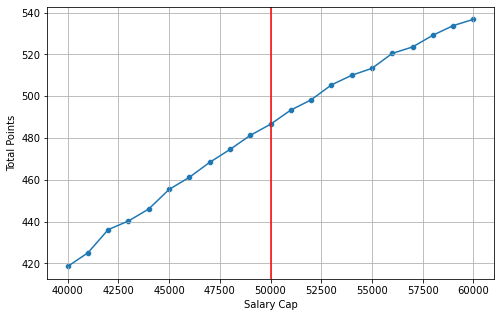

In [47]:
plt.figure(figsize = (8,5))
sns.scatterplot(x = 'Salary Cap', y = 'Total Points', data = df)
sns.lineplot(x = 'Salary Cap', y = 'Total Points', data = df)
plt.grid()
plt.axvline(x = 50000, color = "red")
plt.show()

#### Print Slack for Players and Salary Constraints

In [48]:
#slack constraints for season data
print(model_season.con_players.slack())
print(model_season.con_salary.slack())

0.0
600.0


### M2: Actual Sensitivity Analysis

#### Define Function that Runs M2

In [49]:
def run_model_actual():
    #define lists and dictionaries
    PLAYERS_ACTUAL = list(set(df_actual['Name']))
    totalpoints_actual = df_actual.set_index(['Name'])['totalpoints'].to_dict()
    salary_actual = df_actual.set_index(['Name'])['Salary'].to_dict()
    TEAMS_ACTUAL = df_actual.set_index(['Name'])['Team'].to_dict()
    POSITIONS_ACTUAL = df_actual.set_index(['Name'])['Position'].to_dict()
    teams_actual = df_actual.groupby('Team')
    
    #define model
    model_actual = pe.ConcreteModel()
    
    #indexes
    DV_indexes = ['Position','Name','Salary','Team','totalpoints']
    
    #decision variables
    model_actual.x = pe.Var(PLAYERS_ACTUAL,domain=pe.Binary,initialize=0)
    
    #objective function
    model_actual.obj = pe.Objective(expr=sum([totalpoints_actual[p]*model_actual.x[p] for p in PLAYERS_ACTUAL]),sense=pe.maximize)

    #constraints
    model_actual.con_players = pe.Constraint(expr=sum([model_actual.x[p] for p in PLAYERS_ACTUAL])==9)
    model_actual.con_salary = pe.Constraint(expr=sum([model_actual.x[p]*salary_actual[p] for p in PLAYERS_ACTUAL])<=salarycap)
    model_actual.con_teams = pe.Constraint(expr=sum(model_actual.x[p] for p in PLAYERS_ACTUAL if teams_actual['Team']) >= 3)
    model_actual.con_center = pe.Constraint(expr=sum(model_actual.x[p] for p in PLAYERS_ACTUAL if 'C' in POSITIONS_ACTUAL[p]) >= 2)
    model_actual.con_wings = pe.Constraint(expr=sum(model_actual.x[p] for p in PLAYERS_ACTUAL if 'LW' in POSITIONS_ACTUAL[p] or 'RW' in POSITIONS_ACTUAL[p]) >= 3)
    model_actual.con_defenders = pe.Constraint(expr=sum(model_actual.x[p] for p in PLAYERS_ACTUAL if 'D' in POSITIONS_ACTUAL[p]) >= 2)
    model_actual.con_goalie = pe.Constraint(expr=sum(model_actual.x[p] for p in PLAYERS_ACTUAL if 'G' in POSITIONS_ACTUAL[p]) == 1)
    
    #solve model
    opt = pe.SolverFactory('glpk')
    success = opt.solve(model_actual,tee=True)
    print(success.solver.status, success.solver.termination_condition)
    
    return model_actual

#### Test Salary Cap Values 40,000 to 60,000

In [50]:
#change salary cap, test values 40,000 to 60,000
new_salary_cap = [i*1000 for i in list(range(40,61))]
obj_list_actual = []
for val in new_salary_cap:
    salarycap = val
    model_actual = run_model_actual() 
    obj_list_actual.append(model_actual.obj.expr())
zip_list = list(zip(new_salary_cap,obj_list_actual))
df_actual_sensitivity = pd.DataFrame(zip_list,columns=['Salary Cap','Total Points'])

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpcu30bve3.glpk.raw
 --wglp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp5yc83k4z.glpk.glp
 --cpxlp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpuxt0ypsq.pyomo.lp
Reading problem data from '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpuxt0ypsq.pyomo.lp'...
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpuxt0ypsq.pyomo.lp:1307: warning: lower bound of variable 'x1' redefined
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpuxt0ypsq.pyomo.lp:1307: warning: upper bound of variable 'x1' redefined
8 rows, 217 columns, 865 non-zeros
216 integer variables, all of which are binary
1523 lines were read
Writing problem data to '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp5yc83k4z.glpk.glp'...
1295 lines were written
GLPK Integer Optimizer, v4.65
8 rows, 217 columns, 865 non-zeros
216 integer variables, all of which are binary

ok optimal
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp75o4vt8k.glpk.raw
 --wglp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp79f9v1jh.glpk.glp
 --cpxlp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp_7lll_ux.pyomo.lp
Reading problem data from '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp_7lll_ux.pyomo.lp'...
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp_7lll_ux.pyomo.lp:1307: warning: lower bound of variable 'x1' redefined
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp_7lll_ux.pyomo.lp:1307: warning: upper bound of variable 'x1' redefined
8 rows, 217 columns, 865 non-zeros
216 integer variables, all of which are binary
1523 lines were read
Writing problem data to '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp79f9v1jh.glpk.glp'...
1295 lines were written
GLPK Integer Optimizer, v4.65
8 rows, 217 columns, 865 non-zeros
216 integer variables, all of which

ok optimal
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmps27g4dew.glpk.raw
 --wglp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpkbvzsdd6.glpk.glp
 --cpxlp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmps7i6rngf.pyomo.lp
Reading problem data from '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmps7i6rngf.pyomo.lp'...
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmps7i6rngf.pyomo.lp:1307: warning: lower bound of variable 'x1' redefined
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmps7i6rngf.pyomo.lp:1307: warning: upper bound of variable 'x1' redefined
8 rows, 217 columns, 865 non-zeros
216 integer variables, all of which are binary
1523 lines were read
Writing problem data to '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpkbvzsdd6.glpk.glp'...
1295 lines were written
GLPK Integer Optimizer, v4.65
8 rows, 217 columns, 865 non-zeros
216 integer variables, all of which

ok optimal
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpg0fxzhy3.glpk.raw
 --wglp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpzxe5jaef.glpk.glp
 --cpxlp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpnrq39hee.pyomo.lp
Reading problem data from '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpnrq39hee.pyomo.lp'...
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpnrq39hee.pyomo.lp:1307: warning: lower bound of variable 'x1' redefined
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpnrq39hee.pyomo.lp:1307: warning: upper bound of variable 'x1' redefined
8 rows, 217 columns, 865 non-zeros
216 integer variables, all of which are binary
1523 lines were read
Writing problem data to '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpzxe5jaef.glpk.glp'...
1295 lines were written
GLPK Integer Optimizer, v4.65
8 rows, 217 columns, 865 non-zeros
216 integer variables, all of which

ok optimal
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp5gw63i2b.glpk.raw
 --wglp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpff15h8kj.glpk.glp
 --cpxlp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp3zpvgwdv.pyomo.lp
Reading problem data from '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp3zpvgwdv.pyomo.lp'...
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp3zpvgwdv.pyomo.lp:1307: warning: lower bound of variable 'x1' redefined
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp3zpvgwdv.pyomo.lp:1307: warning: upper bound of variable 'x1' redefined
8 rows, 217 columns, 865 non-zeros
216 integer variables, all of which are binary
1523 lines were read
Writing problem data to '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpff15h8kj.glpk.glp'...
1295 lines were written
GLPK Integer Optimizer, v4.65
8 rows, 217 columns, 865 non-zeros
216 integer variables, all of which

ok optimal
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpc64sdw7s.glpk.raw
 --wglp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpb973xwgo.glpk.glp
 --cpxlp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpulv055v6.pyomo.lp
Reading problem data from '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpulv055v6.pyomo.lp'...
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpulv055v6.pyomo.lp:1307: warning: lower bound of variable 'x1' redefined
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpulv055v6.pyomo.lp:1307: warning: upper bound of variable 'x1' redefined
8 rows, 217 columns, 865 non-zeros
216 integer variables, all of which are binary
1523 lines were read
Writing problem data to '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpb973xwgo.glpk.glp'...
1295 lines were written
GLPK Integer Optimizer, v4.65
8 rows, 217 columns, 865 non-zeros
216 integer variables, all of which

#### Print Total Points for Each Salary Cap Value

In [51]:
df_actual_sensitivity

,Salary Cap,Total Points
0,40000,273.3
1,41000,280.6
2,42000,282.4
3,43000,290.3
4,44000,298.3
5,45000,300.2
6,46000,301.7
7,47000,306.1
8,48000,307.6
9,49000,307.6


#### Print Optimal Lineup for Each Salary Cap Value

In [52]:
DV_list_actual = []
for val in new_salary_cap:
    DV_curr_list = []
    salarycap = val
    model_actual = run_model_actual()
    for DV in model_actual.component_objects(pe.Var): #each origin
        for c in DV: #each destination
            if DV[c].value==1.0:
                DV_curr_list.append(DV[c].name)
    DV_list_actual.append(DV_curr_list)
print(DV_list_actual)

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp0fu49nbf.glpk.raw
 --wglp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmplgebs1pq.glpk.glp
 --cpxlp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpu1oan082.pyomo.lp
Reading problem data from '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpu1oan082.pyomo.lp'...
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpu1oan082.pyomo.lp:1307: warning: lower bound of variable 'x1' redefined
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpu1oan082.pyomo.lp:1307: warning: upper bound of variable 'x1' redefined
8 rows, 217 columns, 865 non-zeros
216 integer variables, all of which are binary
1523 lines were read
Writing problem data to '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmplgebs1pq.glpk.glp'...
1295 lines were written
GLPK Integer Optimizer, v4.65
8 rows, 217 columns, 865 non-zeros
216 integer variables, all of which are binary

ok optimal
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpy_3jg52o.glpk.raw
 --wglp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpuehhhyg8.glpk.glp
 --cpxlp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpc9fzq3e8.pyomo.lp
Reading problem data from '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpc9fzq3e8.pyomo.lp'...
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpc9fzq3e8.pyomo.lp:1307: warning: lower bound of variable 'x1' redefined
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpc9fzq3e8.pyomo.lp:1307: warning: upper bound of variable 'x1' redefined
8 rows, 217 columns, 865 non-zeros
216 integer variables, all of which are binary
1523 lines were read
Writing problem data to '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpuehhhyg8.glpk.glp'...
1295 lines were written
GLPK Integer Optimizer, v4.65
8 rows, 217 columns, 865 non-zeros
216 integer variables, all of which

ok optimal
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp420naglt.glpk.raw
 --wglp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpqzcz8wo9.glpk.glp
 --cpxlp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpo1t1yvdd.pyomo.lp
Reading problem data from '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpo1t1yvdd.pyomo.lp'...
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpo1t1yvdd.pyomo.lp:1307: warning: lower bound of variable 'x1' redefined
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpo1t1yvdd.pyomo.lp:1307: warning: upper bound of variable 'x1' redefined
8 rows, 217 columns, 865 non-zeros
216 integer variables, all of which are binary
1523 lines were read
Writing problem data to '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpqzcz8wo9.glpk.glp'...
1295 lines were written
GLPK Integer Optimizer, v4.65
8 rows, 217 columns, 865 non-zeros
216 integer variables, all of which

ok optimal
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpxz7dnsnx.glpk.raw
 --wglp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpr4irjt3a.glpk.glp
 --cpxlp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpvk3a1inb.pyomo.lp
Reading problem data from '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpvk3a1inb.pyomo.lp'...
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpvk3a1inb.pyomo.lp:1307: warning: lower bound of variable 'x1' redefined
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpvk3a1inb.pyomo.lp:1307: warning: upper bound of variable 'x1' redefined
8 rows, 217 columns, 865 non-zeros
216 integer variables, all of which are binary
1523 lines were read
Writing problem data to '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpr4irjt3a.glpk.glp'...
1295 lines were written
GLPK Integer Optimizer, v4.65
8 rows, 217 columns, 865 non-zeros
216 integer variables, all of which

ok optimal
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpgr7hl5z0.glpk.raw
 --wglp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp3ukfutr8.glpk.glp
 --cpxlp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpils6uv1_.pyomo.lp
Reading problem data from '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpils6uv1_.pyomo.lp'...
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpils6uv1_.pyomo.lp:1307: warning: lower bound of variable 'x1' redefined
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpils6uv1_.pyomo.lp:1307: warning: upper bound of variable 'x1' redefined
8 rows, 217 columns, 865 non-zeros
216 integer variables, all of which are binary
1523 lines were read
Writing problem data to '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp3ukfutr8.glpk.glp'...
1295 lines were written
GLPK Integer Optimizer, v4.65
8 rows, 217 columns, 865 non-zeros
216 integer variables, all of which

ok optimal
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmppdb49rlt.glpk.raw
 --wglp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp4uavurvo.glpk.glp
 --cpxlp /var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpltw1op3o.pyomo.lp
Reading problem data from '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpltw1op3o.pyomo.lp'...
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpltw1op3o.pyomo.lp:1307: warning: lower bound of variable 'x1' redefined
/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmpltw1op3o.pyomo.lp:1307: warning: upper bound of variable 'x1' redefined
8 rows, 217 columns, 865 non-zeros
216 integer variables, all of which are binary
1523 lines were read
Writing problem data to '/var/folders/1q/xp3s_g4562n85d_j0xm_sp080000gn/T/tmp4uavurvo.glpk.glp'...
1295 lines were written
GLPK Integer Optimizer, v4.65
8 rows, 217 columns, 865 non-zeros
216 integer variables, all of which

In [53]:
df = pd.DataFrame(DV_list_actual)
df['Total Points'] = df_actual_sensitivity['Total Points']
df['Salary Cap'] = df_actual_sensitivity['Salary Cap']
df

,0,1,2,3,4,5,6,7,8,Total Points,Salary Cap
0,x[Jesper Boqvist],x[Artemi Panarin],x[Nick Schmaltz],x[Morgan Rielly],x[Pheonix Copley],x[Kent Johnson],x[Juuso Valimaki],x[Rasmus Kupari],x[Adrian Kempe],273.3,40000
1,x[Artemi Panarin],x[Nick Schmaltz],x[Morgan Rielly],x[Pheonix Copley],x[Kent Johnson],x[Juuso Valimaki],x[Alexander Kerfoot],x[Sean Kuraly],x[Adrian Kempe],280.6,41000
2,x[Boone Jenner],x[Mathieu Olivier],x[Artemi Panarin],x[Morgan Rielly],x[Pheonix Copley],x[Kent Johnson],x[Juuso Valimaki],x[Sean Kuraly],x[Adrian Kempe],282.4,42000
3,x[Boone Jenner],x[Tomas Tatar],x[Artemi Panarin],x[Morgan Rielly],x[Pheonix Copley],x[Kent Johnson],x[Juuso Valimaki],x[Sean Kuraly],x[Adrian Kempe],290.3,43000
4,x[Boone Jenner],x[Artemi Panarin],x[Nick Schmaltz],x[Morgan Rielly],x[Pheonix Copley],x[Kent Johnson],x[Juuso Valimaki],x[Sean Kuraly],x[Adrian Kempe],298.3,44000
5,x[Boone Jenner],x[Artemi Panarin],x[Nick Schmaltz],x[Morgan Rielly],x[Pheonix Copley],x[Kent Johnson],x[Juuso Valimaki],x[Alexander Kerfoot],x[Adrian Kempe],300.2,45000
6,x[Boone Jenner],x[Artemi Panarin],x[Morgan Rielly],x[Pheonix Copley],x[Kent Johnson],x[Juuso Valimaki],x[Alexander Kerfoot],x[Clayton Keller],x[Adrian Kempe],301.7,46000
7,x[Boone Jenner],x[Artemi Panarin],x[Nick Schmaltz],x[Morgan Rielly],x[Pheonix Copley],x[Kent Johnson],x[Juuso Valimaki],x[Anze Kopitar],x[Adrian Kempe],306.1,47000
8,x[Boone Jenner],x[Artemi Panarin],x[Morgan Rielly],x[Pheonix Copley],x[Kent Johnson],x[Juuso Valimaki],x[Anze Kopitar],x[Clayton Keller],x[Adrian Kempe],307.6,48000
9,x[Boone Jenner],x[Artemi Panarin],x[Morgan Rielly],x[Pheonix Copley],x[Kent Johnson],x[Juuso Valimaki],x[Anze Kopitar],x[Clayton Keller],x[Adrian Kempe],307.6,49000


#### Scatterplot to Show Total Points as Salary Cap Increases

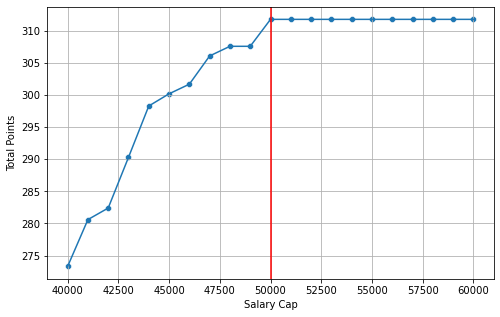

In [54]:
plt.figure(figsize = (8,5))
sns.scatterplot(x = 'Salary Cap', y = 'Total Points', data = df)
sns.lineplot(x = 'Salary Cap', y = 'Total Points', data = df)
plt.grid()
plt.axvline(x = 50000, color = "red")
plt.show()

#### Print Slack for Players and Salary Constraints

In [55]:
#slack constraints for actual data
print(model_actual.con_players.slack())
print(model_actual.con_salary.slack())

0.0
10100.0


##### [Back to Top](#Top)

# 6. Conclusions<a id=6></a>

## 6.1 Tactical Information<a id=6.1></a>

When it came to determining the optimal lineup using the season data, I found that the total points for the lineup while satisfying each of the constraints was 22,512.4. When analyzing the slack for the constraints, I found that there was no slack for either the player or salary constraints, meaning the entire 50,000 was used. When performing sensitivity analysis, testing a range of 40,000 to 60,000, the total points almost directly linearly correlated with the salary increase, which indicates that the lineup changed each time the salary was incremented.

After checking rubric and seeing that average total points per game was required for the season data problem instead of a total, I found that the lineup above was most optimal, producing 486.58 points. However, when re-calculating the slack for the salary constraint, there was 600 unused dollars in the budget, meaning that the full 50,000 was not optimized. While this solution stays in line with the rubric, I think my first solution, the one that calculates total points instead of total points per game, was the best. 

## 6.2 Strategic Information<a id=6.2></a>

Regarding the actual game data that was used in M2, we determined the lineup listed above was the most optimal, yielding 311.8 points and satisfying all of the constraints. When performing sensitivity analysis, the first thing that stuck out to me was that the salary constraint was 10,100 less than the allowed salary cap. However, when I tested a salary cap range from 40,000 to 60,000, the lineup remained the same from 50,000 to 60,000. This means that either the optimal lineup determined earlier in the problem was the best possible and there was simply no need to spend any more money, or there was an issue somewhere else in the problem that I didn't catch.

##### [Back to Top](#Top)

# 7. Model Limitations, Future Improvements and Challenges<a id=7></a>

One of the first observations I made was that there may be a better way of predicting the optimal lineup instead of total points. Maybe take into account time played or other statistics that someone with knowledge of the sport would be wary of. This extra information might increase the accuracy of the model or produce a more optimal lineup. 

My ideal sensitivity analysis would have had the player positions as the column names, which would better show the changes in lineup as the salary cap went up. However I couldn't find out how to assign the positions to the column names and keep them consistent with the positions of the players in each lineup. I would've also liked to include total points per player, team, and position in the sensitivity analysis dataframe, but I couldn't figure out how to make a dictionary that included multiple values per key without wrecking the entire model. Maybe, given more time, I'd be able to make some of these changes. 

##### [Back to Top](#Top)